In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd

from kan import create_dataset, KAN, KANLayer
from kan.MLP import MLP

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import shap


from source import plot_f_2d, plot_f_3d, scatter_prediction_kan, kan_summary_after_fit
from source import lmdKANLayer, lmdKAN, importance_analyse_lmdKAN


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

c:\Users\Gavriil\VS_projects\lambda_KAN\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


-----
-----
## $f_1(x_1, x_2, x_3, x_4)$

## $x_3, x_4$ - normal random

##### $f_1(x_1, x_2, x_3, x_4) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$

c:\Users\Gavriil\VS_projects\lambda_KAN\.venv\lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


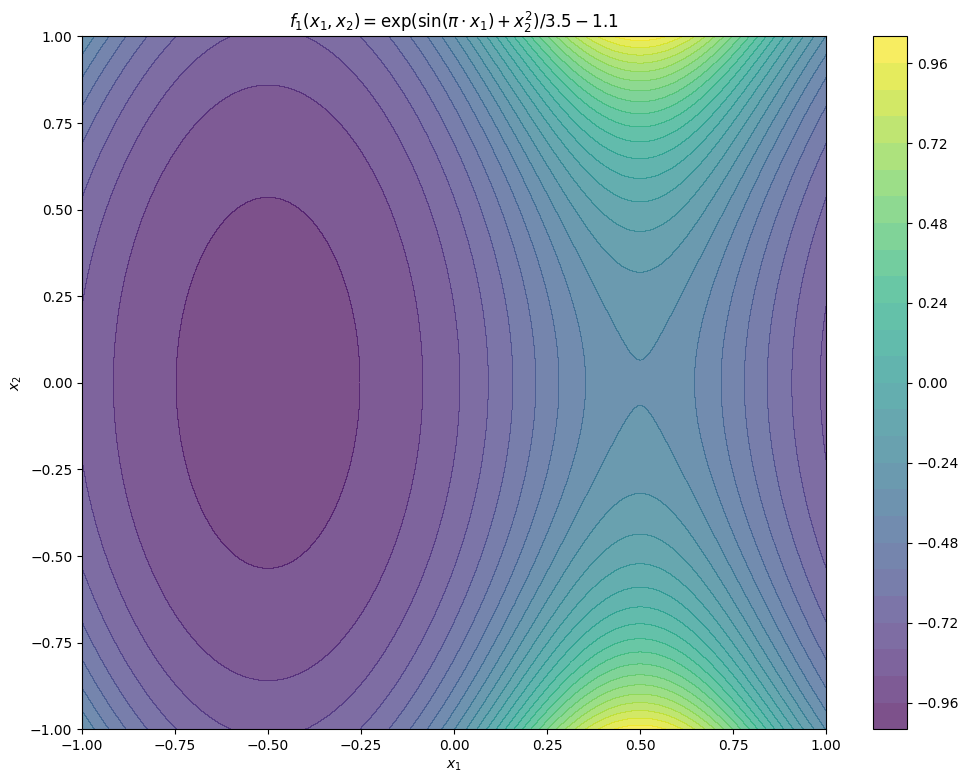

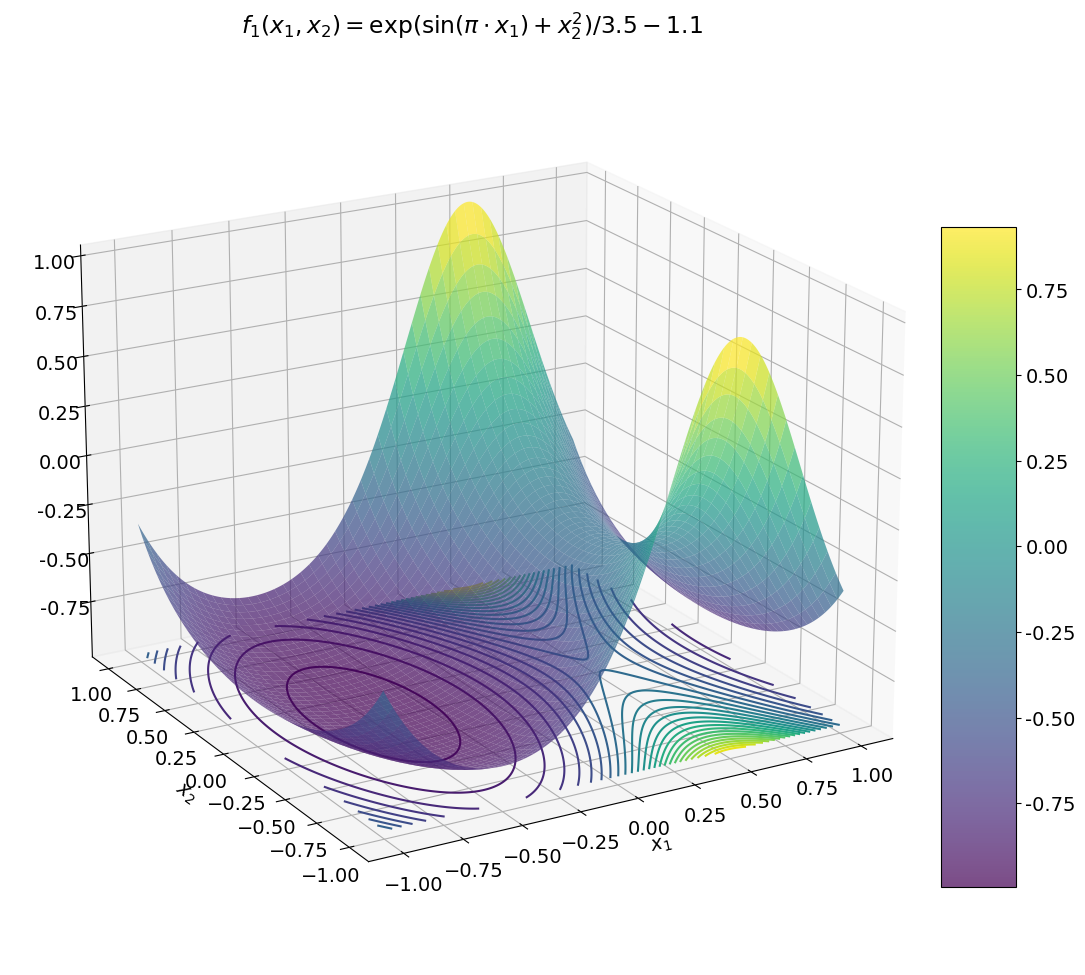

In [2]:
# create dataset
f1 = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2) / 3.5 - 1.1
dataset1 = create_dataset(f1, n_var=4, device=device)

f = f1
dataset = dataset1

plot_f_2d(f1, title='$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')
plot_f_3d(f1, title='$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')

-----
### MLP on $f_1$

№ model trainable params: 246


description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| train_loss: 1.21e-02 | test_loss: 1.67e-02 | reg: 9.46e+01 | : 100%|█| 100/100 [00:18<00:00,  5.49


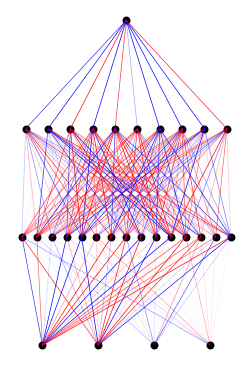

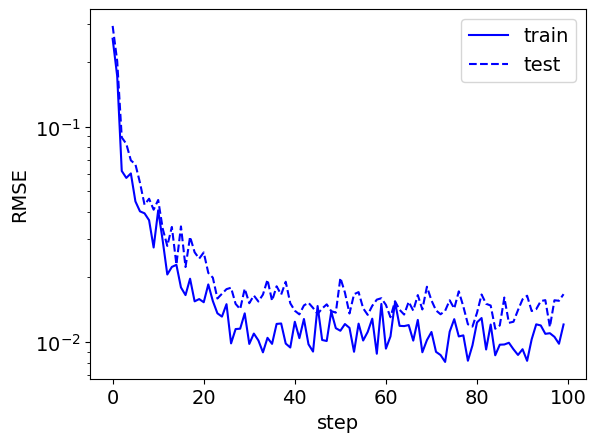

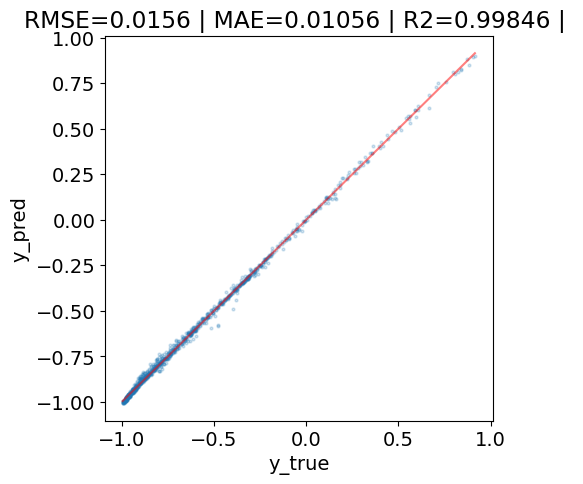

In [3]:
# initialize MLP
model = MLP(width=[4,15,10,1], seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb = 0, batch=250)
kan_summary_after_fit(model, dataset, results)

-----
### KAN on $f_1$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 300


| train_loss: 4.88e-03 | test_loss: 4.14e-03 | reg: 4.00e+00 | : 100%|█| 100/100 [02:12<00:00,  1.33


saving model version 0.1


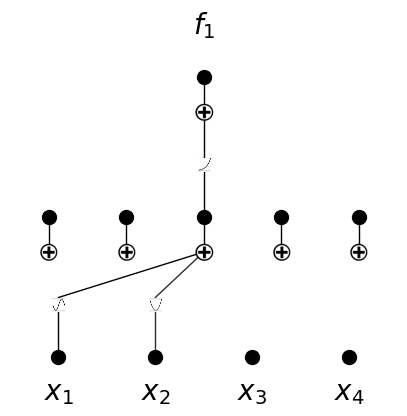

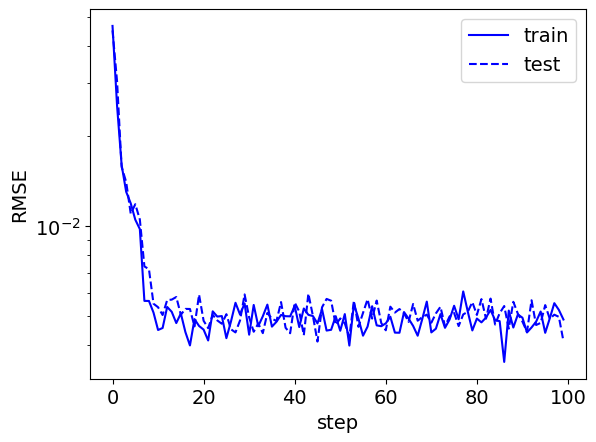

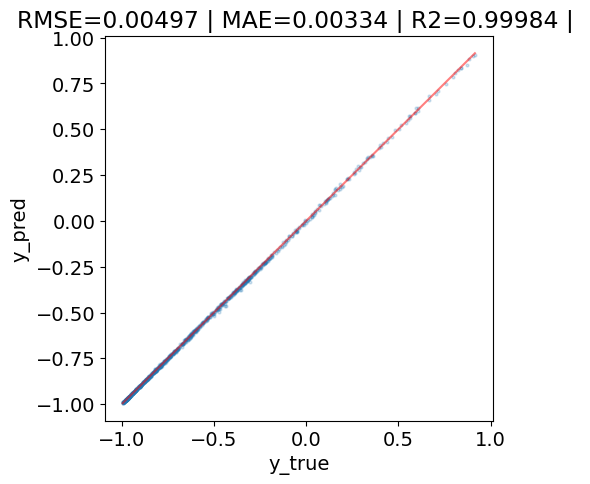

In [4]:
# initialize KAN with G=3
model = KAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb=1e-4, update_grid=False, batch=250)
kan_summary_after_fit(model, dataset, results, in_vars = ['$x_1$', '$x_2$', '$x_3$', '$x_4$'], out_vars = ['$f_1$'])

-----
### $\lambda$-KAN on $f_1$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 184


| train_loss: 7.16e-02 | test_loss: 7.01e-02 | reg: 1.75e+01 | : 100%|█| 150/150 [04:49<00:00,  1.93


saving model version 0.1


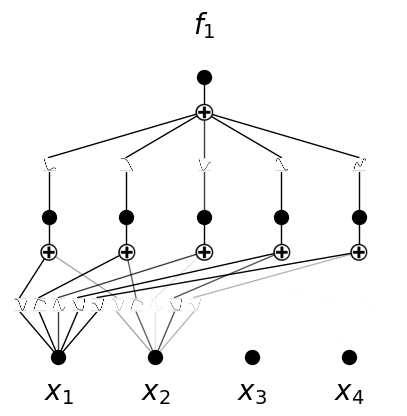

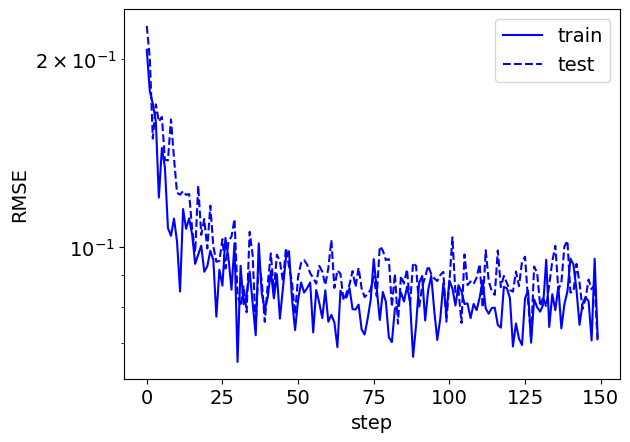

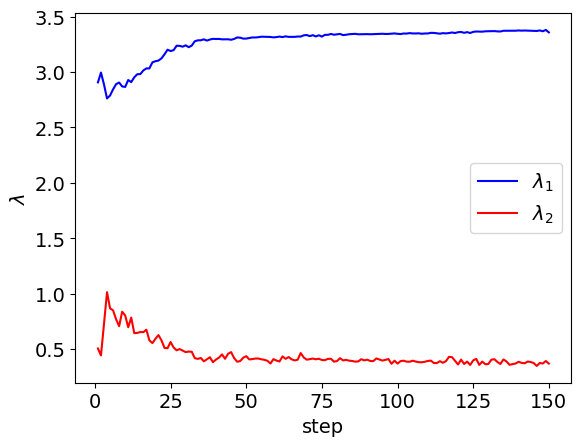

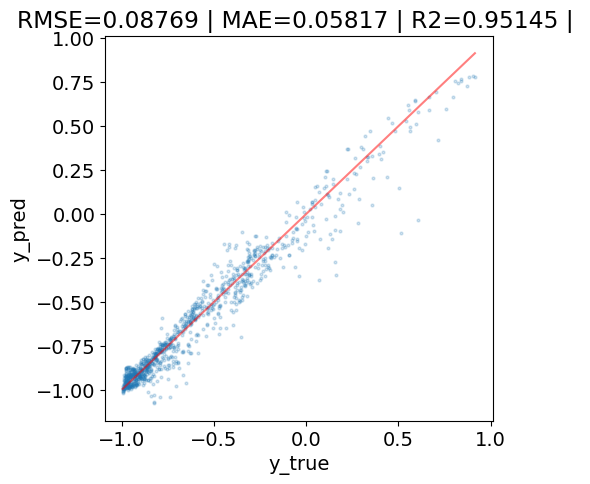

model.act_fun[0].lmd=Parameter containing:
tensor([3.3570e+00, 3.6786e-01, 5.5060e-04, 4.0311e-03], requires_grad=True)


In [6]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)
kan_summary_after_fit(model, dataset, results, lmdKAN=True, in_vars = ['$x_1$', '$x_2$', '$x_3$', '$x_4$'], out_vars = ['$f_1$'])
print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [11:57,  1.39it/s]                          


module of Input importance:


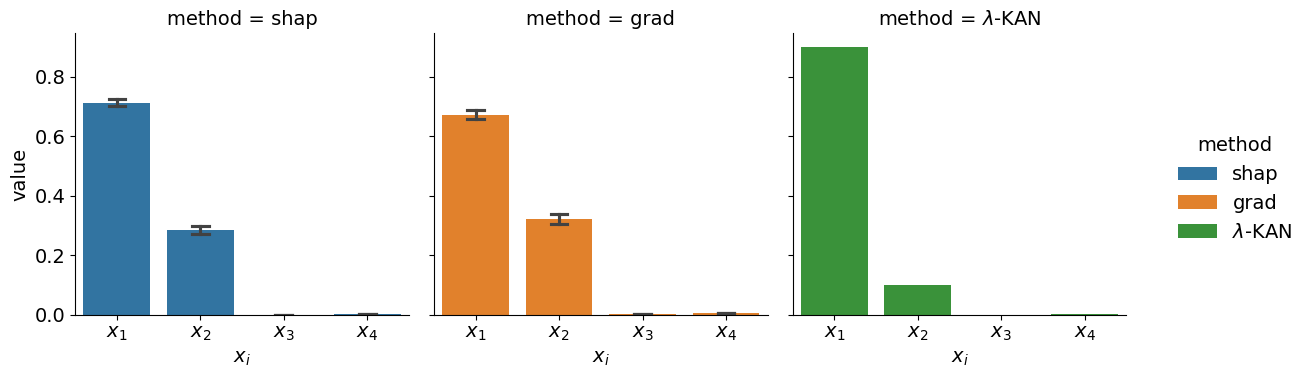

Input importance:


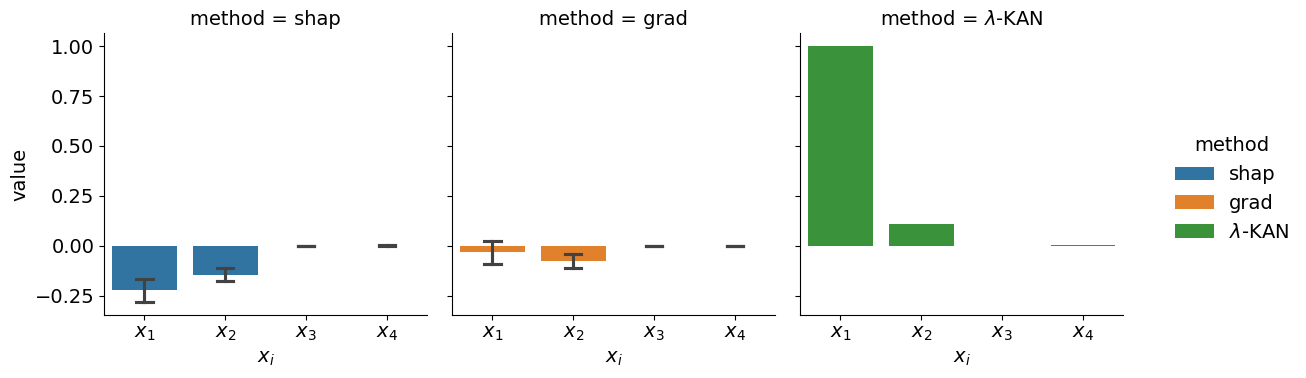

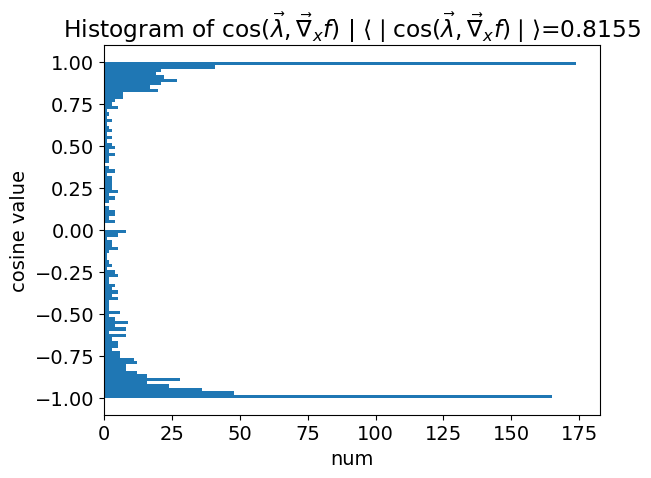

In [7]:
importance_analyse_lmdKAN(model, dataset)

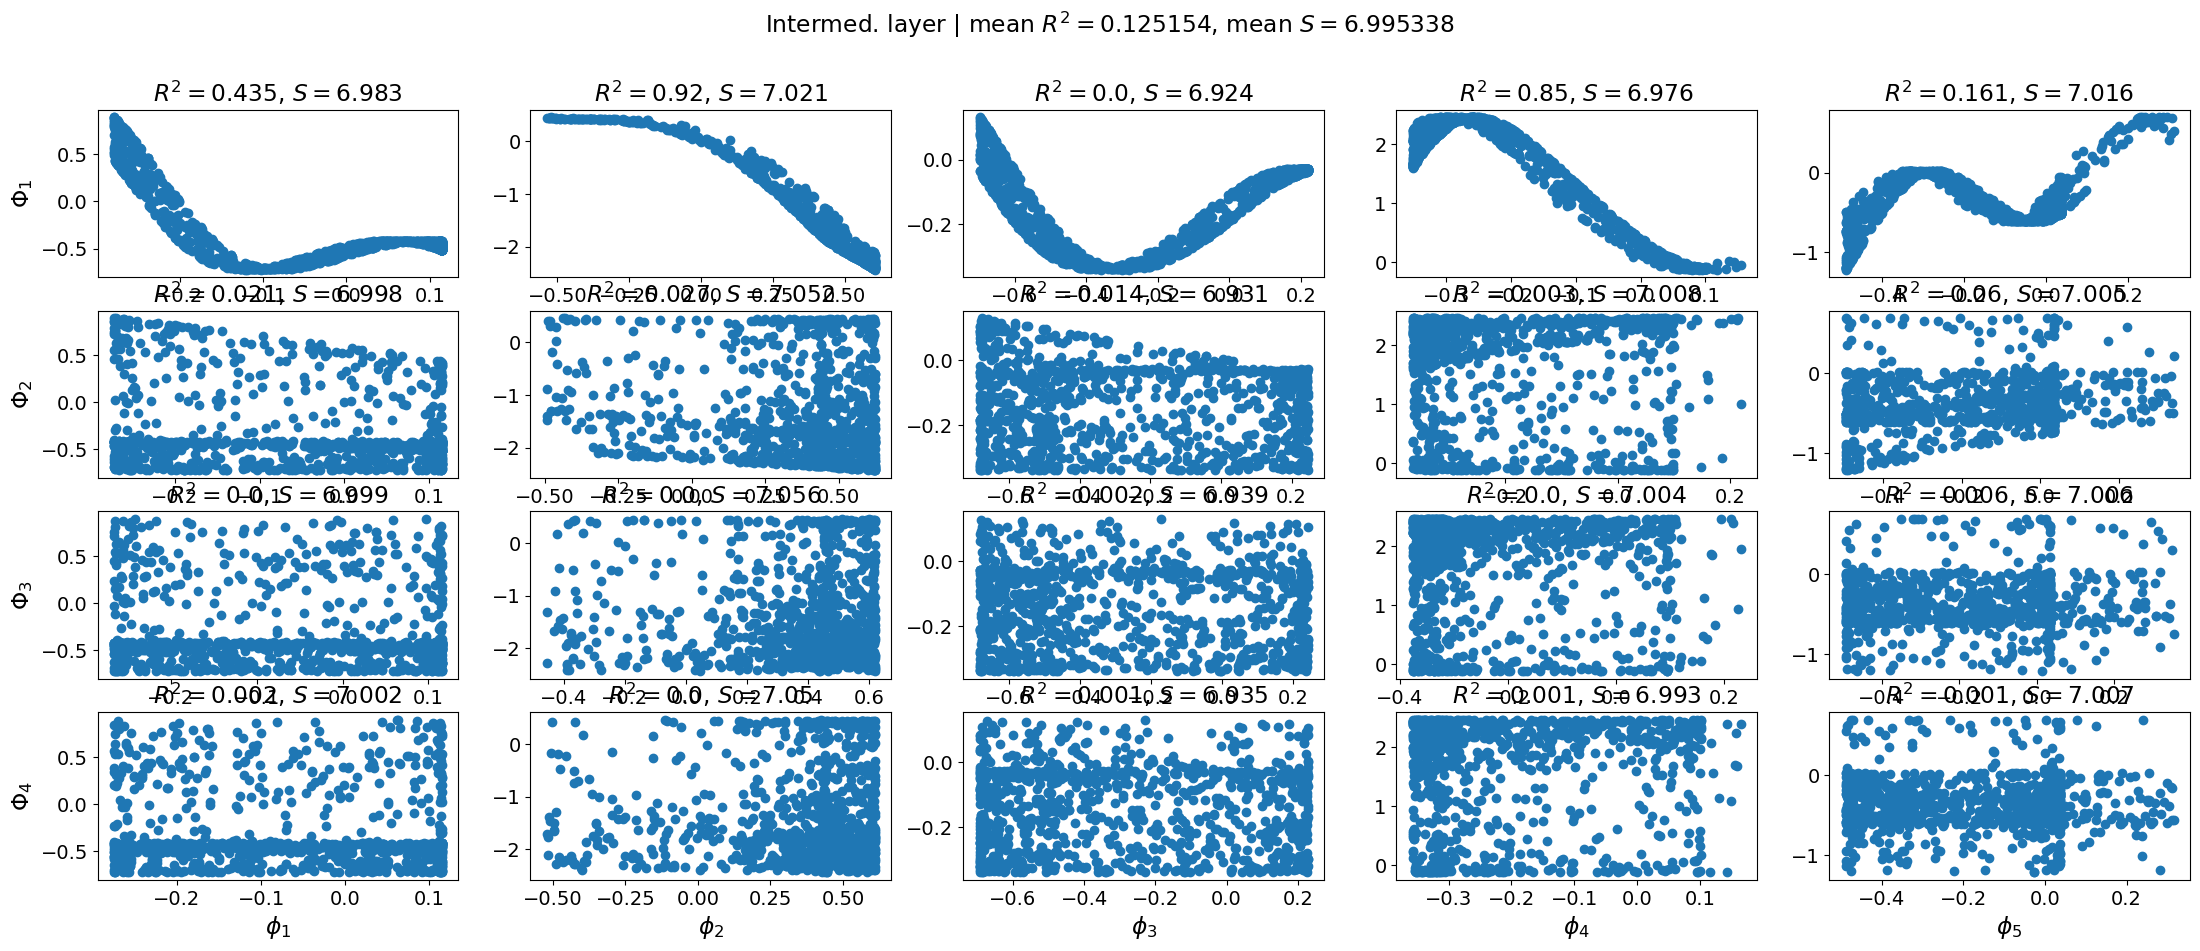

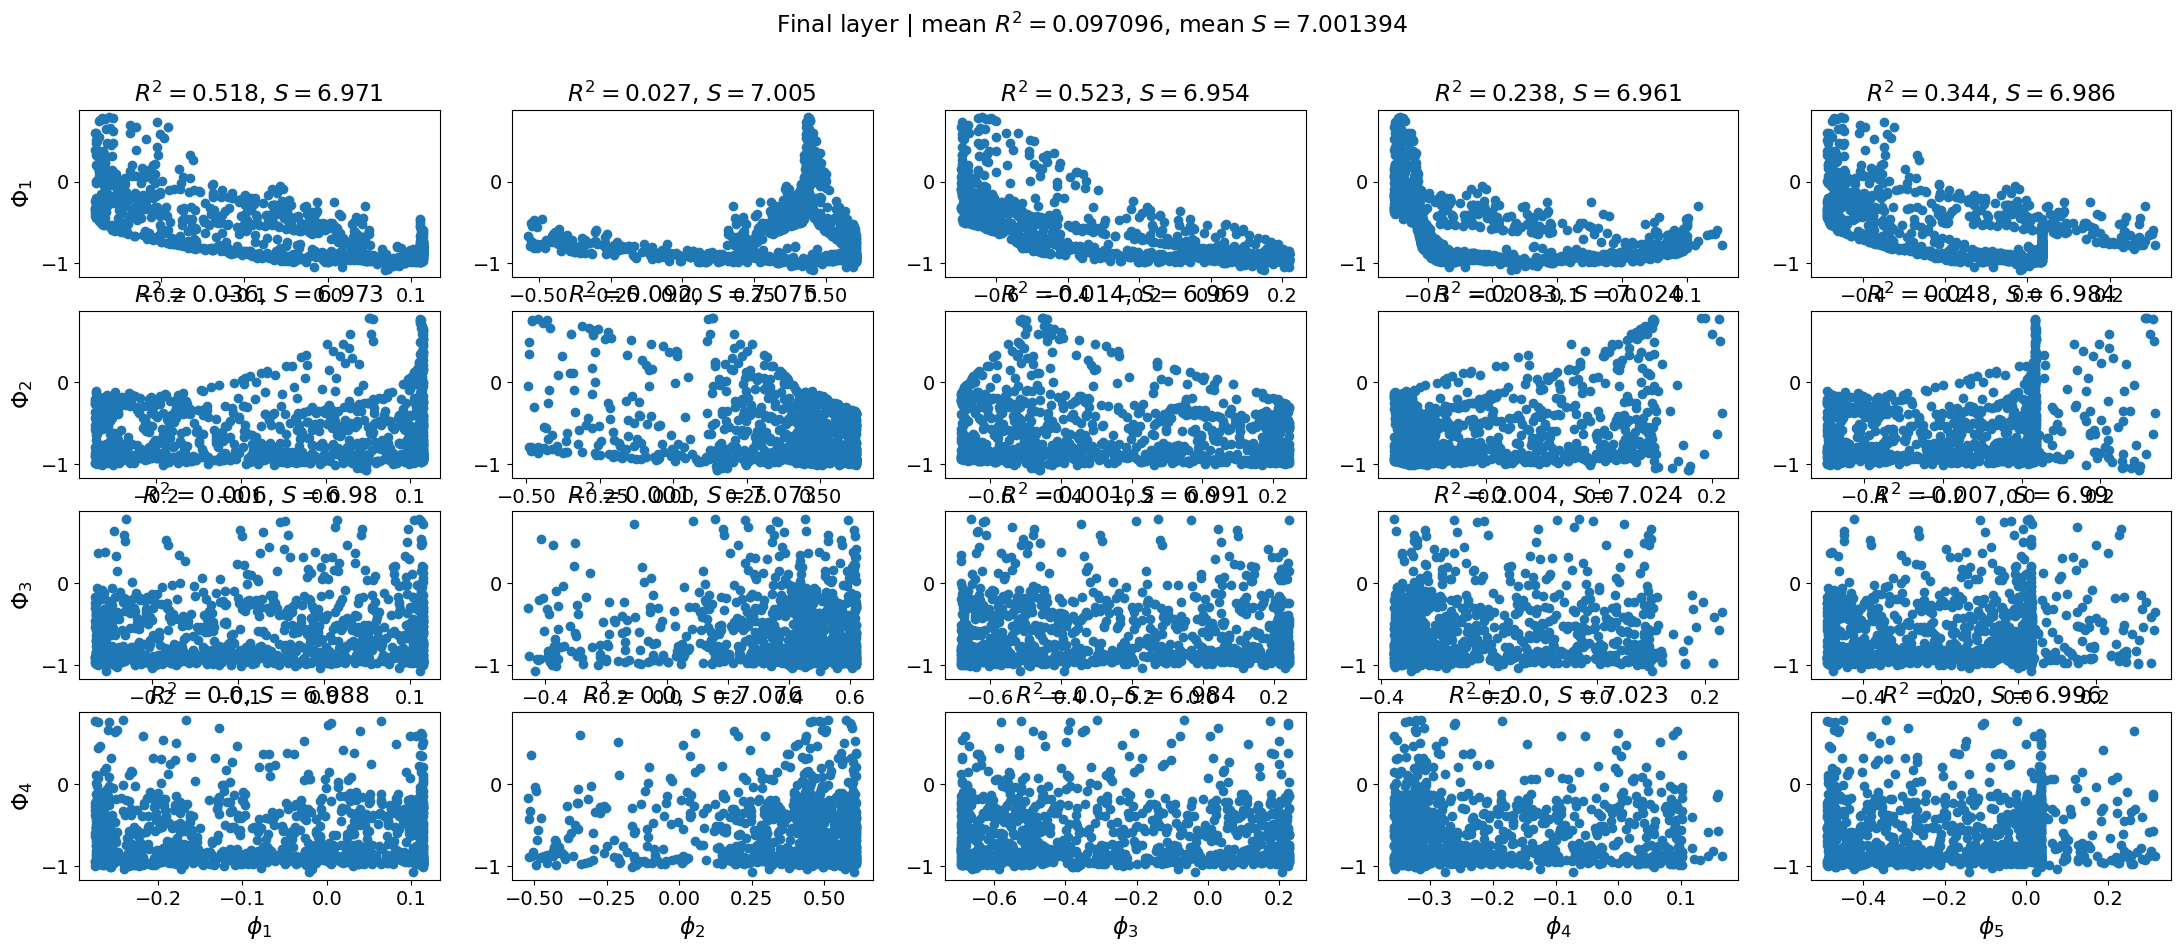

{'mean_r2': 0.09709576557288528, 'mean_matrix_entropy': 7.001393795013428}

In [8]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')


-----
-----
## $f_1(x_1, x_2, x_3, x_4)$

## $x_3, x_4$ - LC($x_3, x_4$) + normal random

##### $f_1(x_1, x_2, x_3, x_4) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$

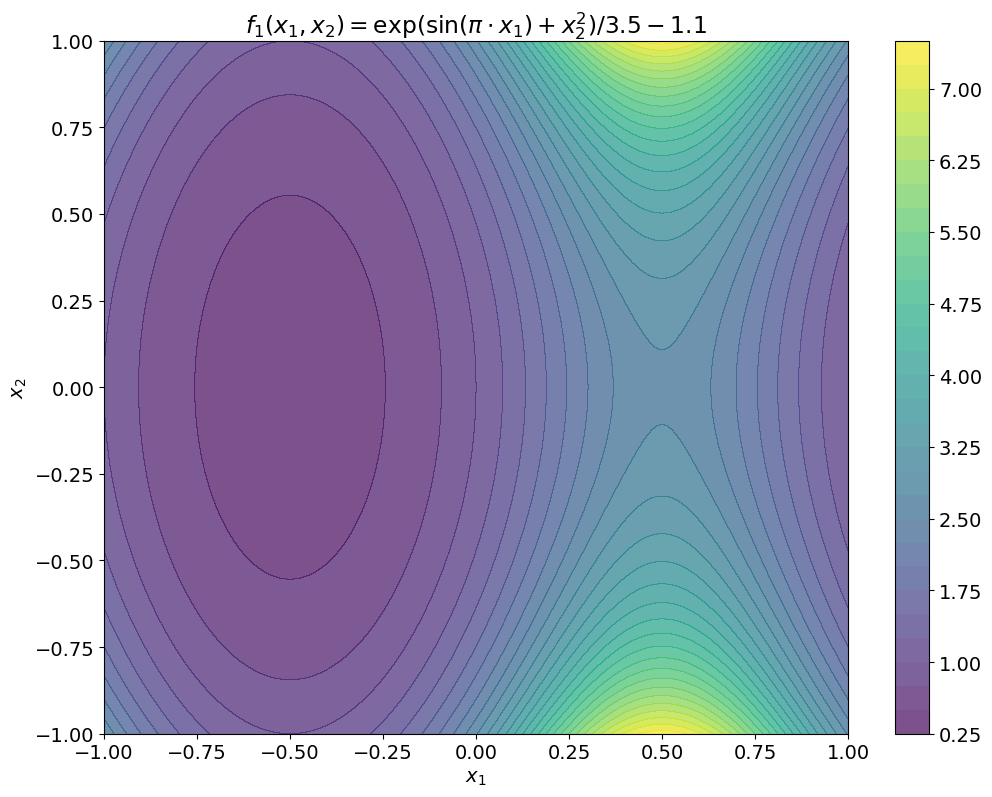

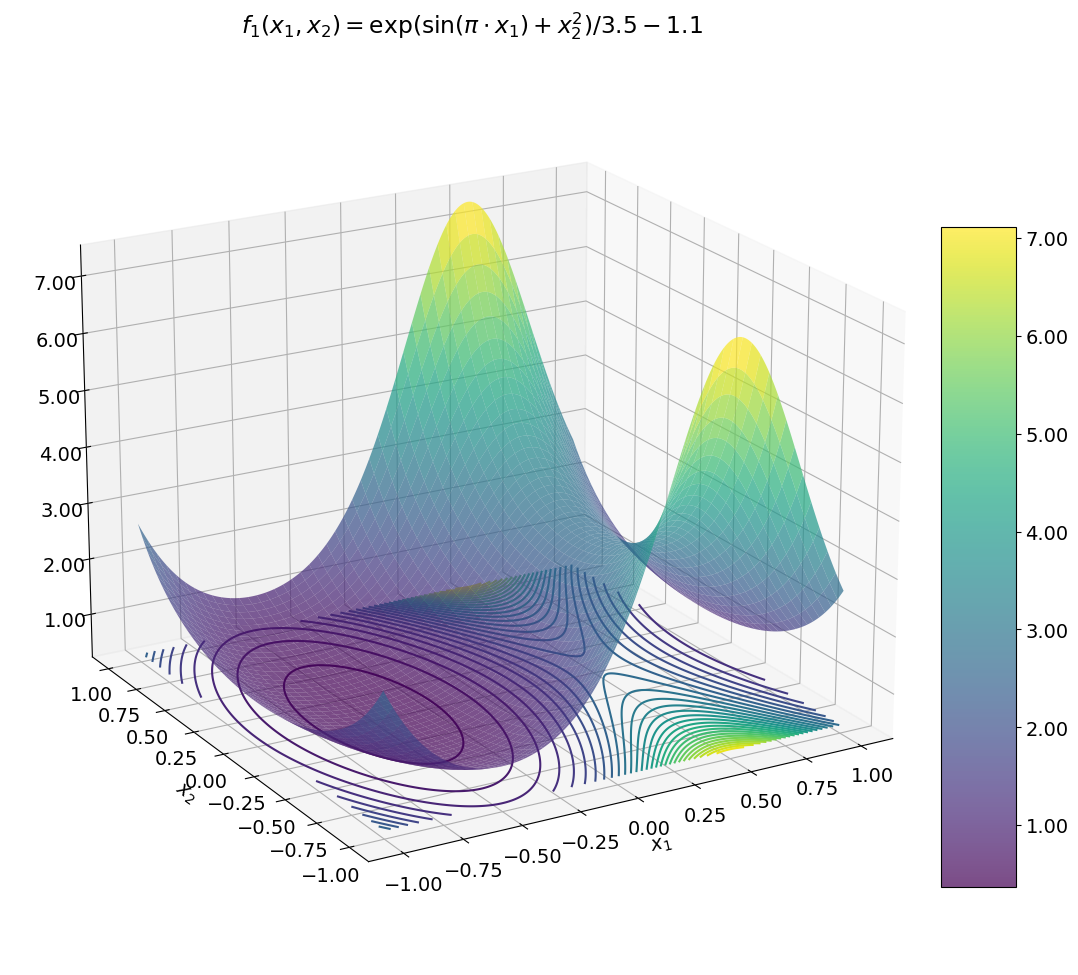

In [9]:
# create dataset
f1 = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset1 = create_dataset(f1, n_var=2, device=device)

# adding new inputs
SNR = 20 #noize_ampl=0.1 with SNR=20
noize_ampl = 10**(-SNR/20)

add_x = torch.stack((2**(-0.5)*dataset1['train_input'][:,0] + 2**(-0.5)*dataset1['train_input'][:,1] + noize_ampl*torch.randn(*dataset1['train_input'][:,0].shape),
                     2**(-0.5)*dataset1['train_input'][:,0] - 2**(-0.5)*dataset1['train_input'][:,1] + noize_ampl*torch.randn(*dataset1['train_input'][:,0].shape))
                     , dim=1)
dataset1['train_input'] = torch.concat((dataset1['train_input'], add_x), dim=1)

add_x = torch.stack((2**(-0.5)*dataset1['test_input'][:,0] + 2**(-0.5)*dataset1['test_input'][:,1] + noize_ampl*torch.randn(*dataset1['test_input'][:,0].shape),
                     2**(-0.5)*dataset1['test_input'][:,0] - 2**(-0.5)*dataset1['test_input'][:,1] + noize_ampl*torch.randn(*dataset1['test_input'][:,0].shape)), 
                    dim=1)
dataset1['test_input'] = torch.concat((dataset1['test_input'], add_x), dim=1)

f = f1
dataset = dataset1

plot_f_2d(f1, title='$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')
plot_f_3d(f1, title='$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')

-----
### MLP on $f_1$

№ model trainable params: 246


| train_loss: 1.49e-02 | test_loss: 1.81e-02 | reg: 1.15e+02 | : 100%|█| 100/100 [00:26<00:00,  3.78


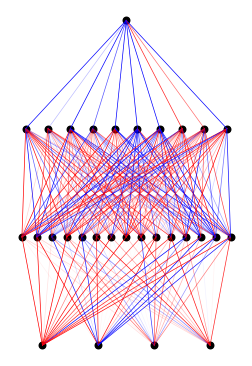

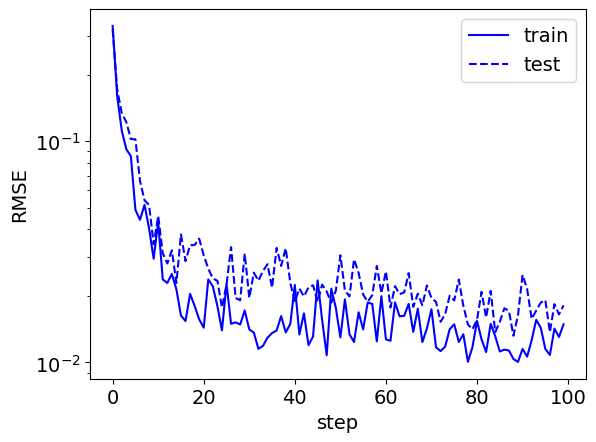

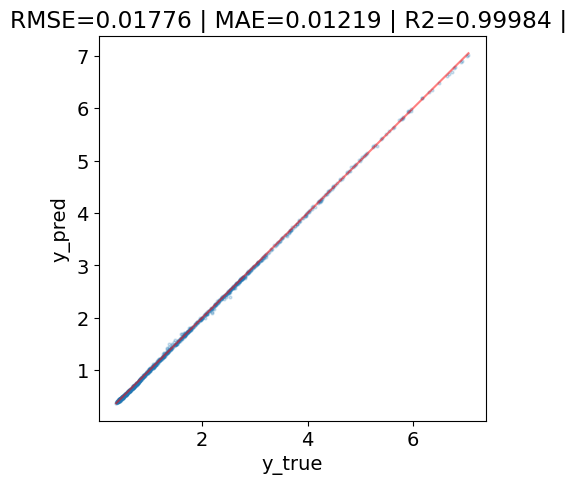

In [10]:
# initialize MLP
model = MLP(width=[4,15,10,1], seed=3, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb = 0, batch=250)
kan_summary_after_fit(model, dataset, results)

-----
### KAN on $f_1$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 300


| train_loss: 6.55e-03 | test_loss: 6.08e-03 | reg: 7.20e+00 | : 100%|█| 100/100 [04:28<00:00,  2.69


saving model version 0.1


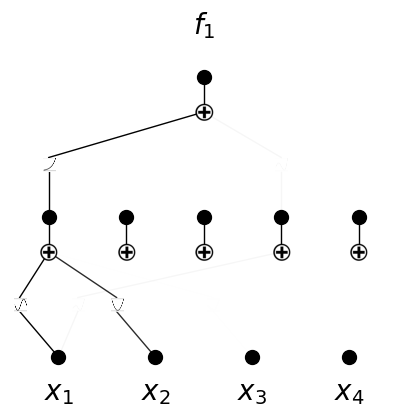

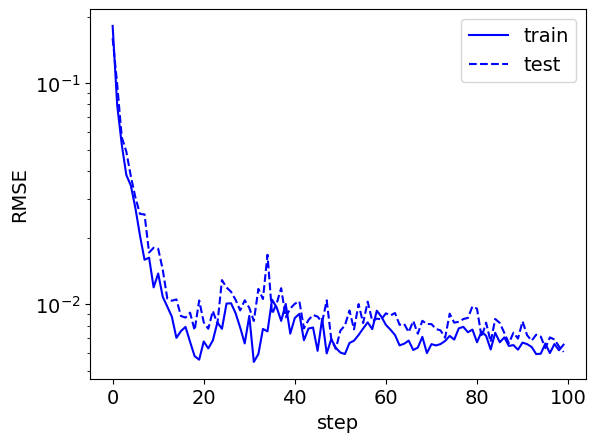

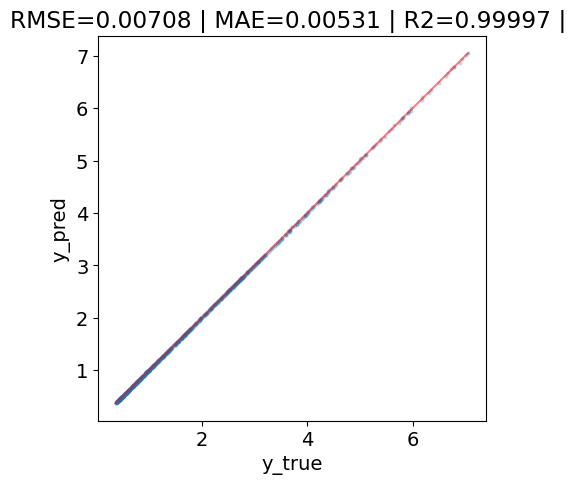

In [11]:
# initialize KAN with G=3
model = KAN(width=[4,5,1], grid=3, k=3, seed=2, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb=1e-4, update_grid=False, batch=250)
kan_summary_after_fit(model, dataset, results, in_vars = ['$x_1$', '$x_2$', '$x_3$', '$x_4$'], out_vars = ['$f_1$'])

-----
### $\lambda$-KAN on $f_1$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 184


description:   0%|                                                          | 0/150 [00:00<?, ?it/s]

| train_loss: 2.92e-01 | test_loss: 2.62e-01 | reg: 3.16e+01 | : 100%|█| 150/150 [01:07<00:00,  2.23


saving model version 0.1


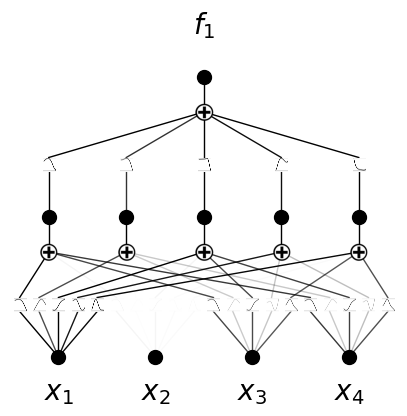

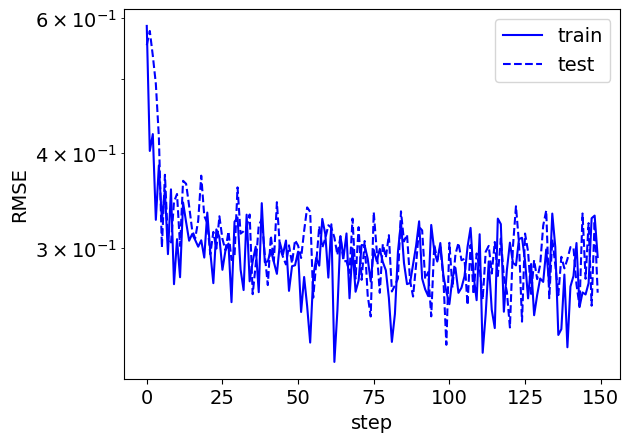

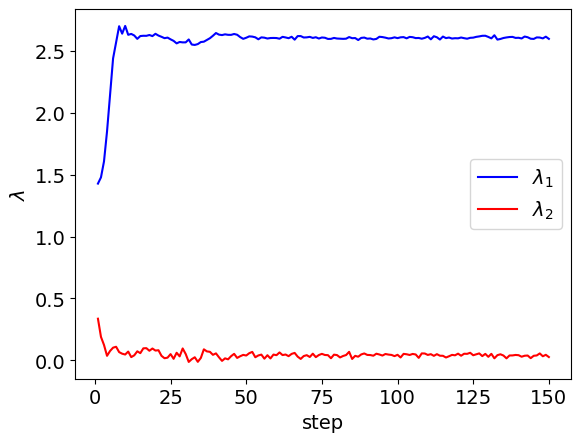

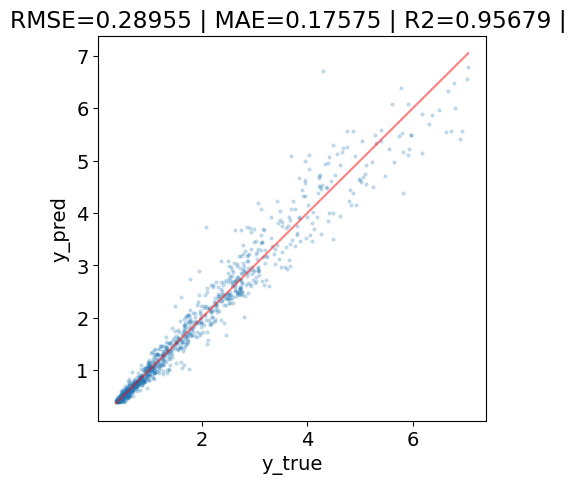

model.act_fun[0].lmd=Parameter containing:
tensor([2.5979, 0.0258, 0.6577, 0.6995], requires_grad=True)


In [13]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[4,5,1], grid=3, k=3, seed=2, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)
kan_summary_after_fit(model, dataset, results, lmdKAN=True, in_vars = ['$x_1$', '$x_2$', '$x_3$', '$x_4$'], out_vars = ['$f_1$'])
print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:32, 22.59it/s]                         


module of Input importance:


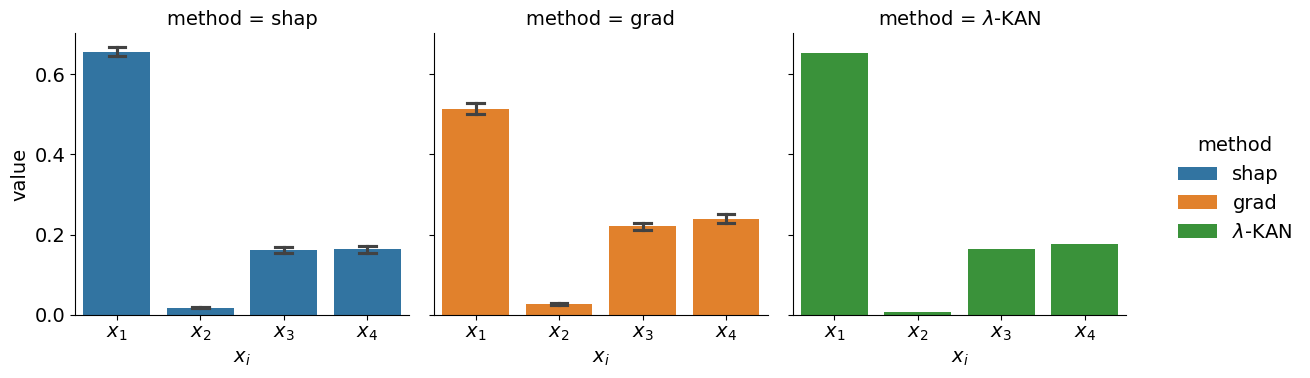

Input importance:


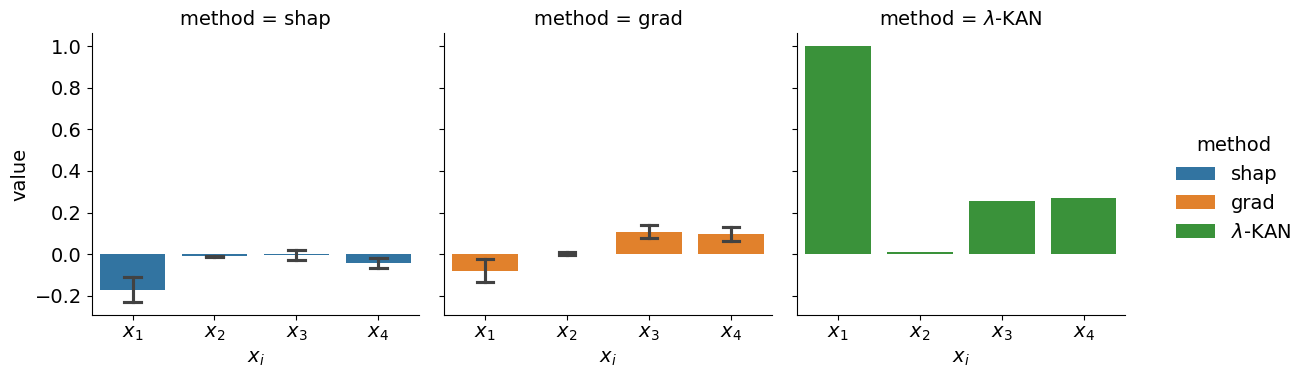

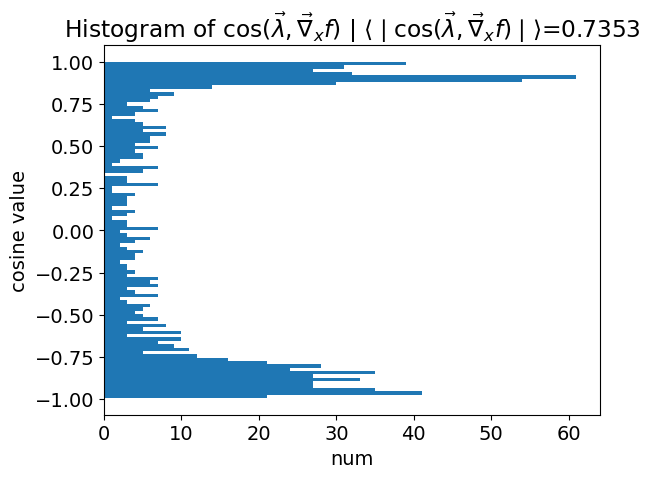

In [14]:
importance_analyse_lmdKAN(model, dataset)

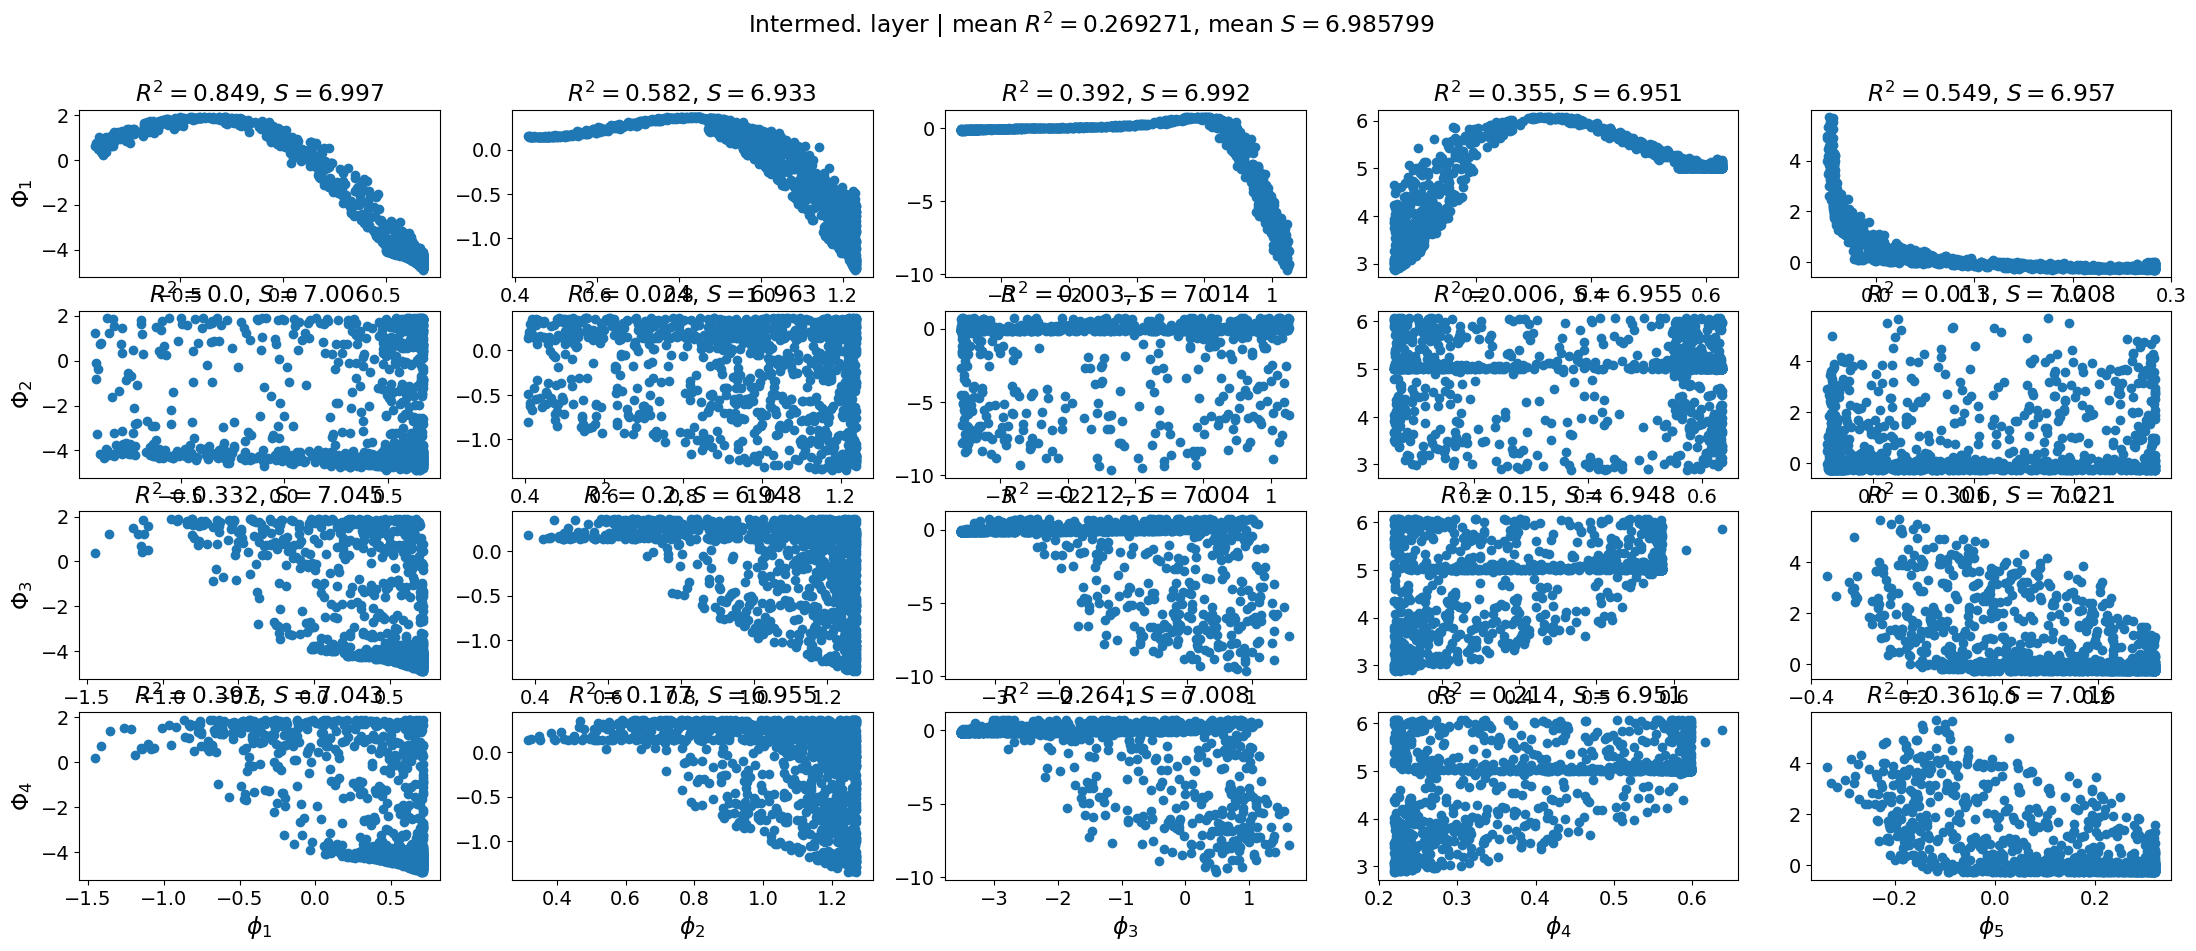

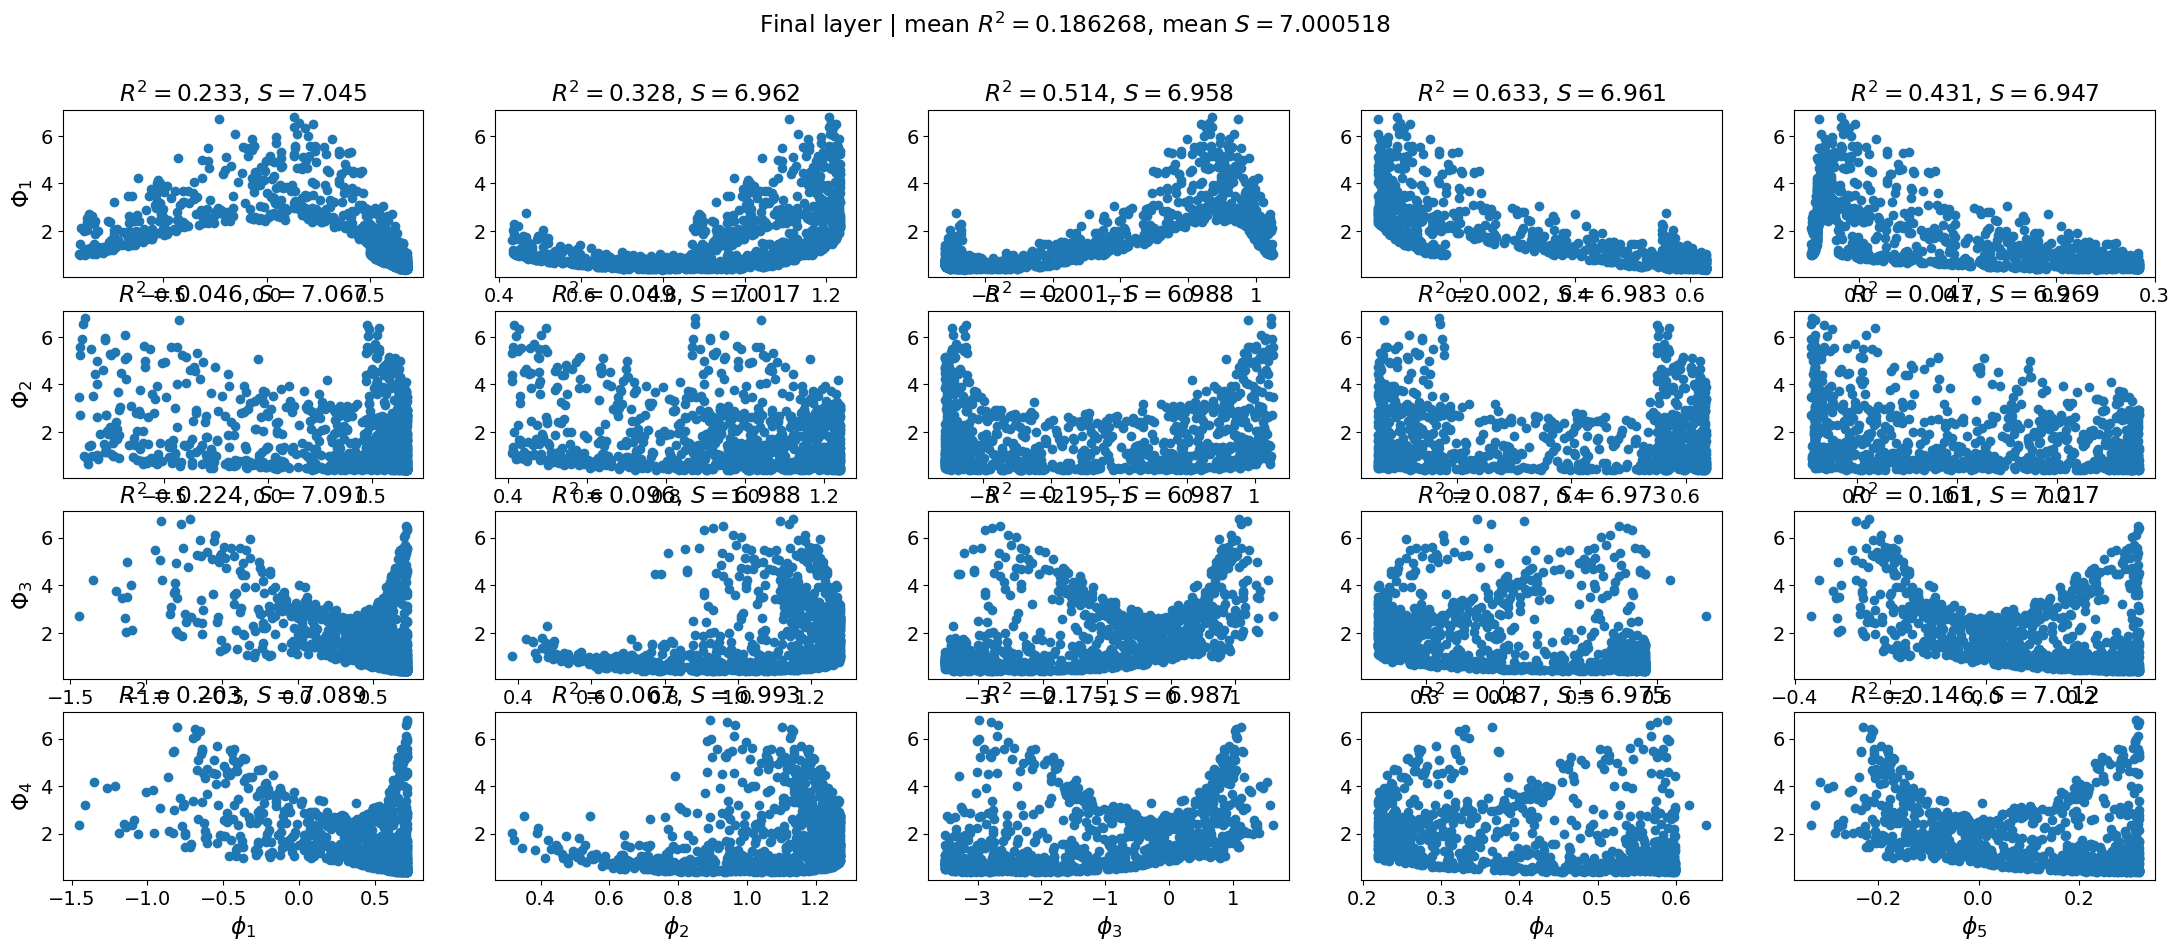

{'mean_r2': 0.18626774385920725, 'mean_matrix_entropy': 7.000517845153809}

In [15]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')